In [1]:
!pip install pandas matplotlib

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
data_path = "./data/simulated_dataset/all_data.csv"

In [4]:
df = pd.read_csv(data_path)

In [5]:
sensor_labels = df["sensor_id"].unique()

In [6]:
id1_sensor = df[df["sensor_id"] == sensor_labels[0]]

In [7]:
id1_sensor["timestamp"] = sorted(pd.to_datetime(id1_sensor["timestamp"]))
subset = id1_sensor[:20000]

/tmp/ipykernel_91074/3123496768.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  id1_sensor["timestamp"] = sorted(pd.to_datetime(id1_sensor["timestamp"]))


In [8]:
id1_sensor[id1_sensor["label"] == 2].count()

timestamp      0
sensor_id      0
temperature    0
label          0
dtype: int64

<Axes: title={'center': 'Temperature over Time'}, xlabel='timestamp'>

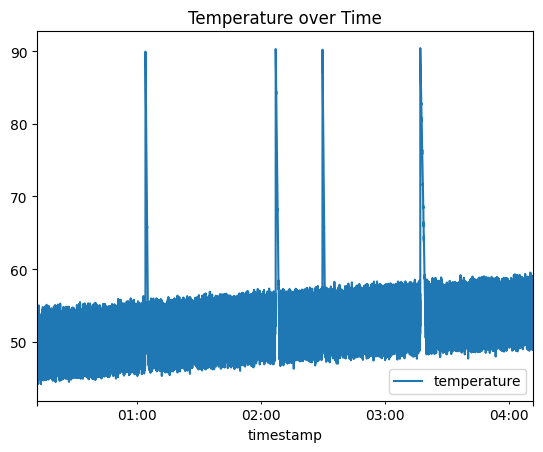

In [9]:
subset.plot.line(x="timestamp", y="temperature", title="Temperature over Time")

# Model

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import numpy as np

2025-10-15 14:22:25.736971: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-15 14:22:25.737856: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-15 14:22:25.812434: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-15 14:22:27.116529: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

In [11]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['unix_timestamp'] = df['timestamp'].apply(lambda x: x.timestamp())

In [12]:
sensor_id = 1
sensor_df = df[df['sensor_id'] == sensor_id].reset_index(drop=True)

In [13]:
n = len(sensor_df)
offset = int(np.floor(n * 0.8))
X_train, y_train = sensor_df['unix_timestamp'][:offset], sensor_df['temperature'][:offset]
X_test, y_test = sensor_df['unix_timestamp'][offset:], sensor_df['temperature'][offset:]

In [14]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(11520,) (11520,)
(2881,) (2881,)


# Understanding Prediction Horizon

The prediction horizon (how far ahead we can predict) depends on two factors:
1. How we structure our sequences
2. Whether we use single-step or multi-step prediction

Currently, your model is structured for single-step prediction, meaning it predicts one time step ahead. Let's modify it to show both single-step and multi-step predictions.

In [ ]:
# Create sequences for time series prediction
def create_sequences(data, seq_length, forecast_horizon):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length - forecast_horizon + 1):
        sequences.append(data[i:(i + seq_length)])
        targets.append(data[i + seq_length:i + seq_length + forecast_horizon])
    return np.array(sequences), np.array(targets)

# Parameters
seq_length = 10  # Look at past 50 time steps
future_steps = 10  # Predict 10 steps ahead

# Prepare sequences
X_train_seq, y_train_seq = create_sequences(y_train.values, seq_length, future_steps)
X_test_seq, y_test_seq = create_sequences(y_test.values, seq_length, future_steps)

In [16]:
X_train_seq.shape, y_train_seq.shape, X_test_seq.shape, y_test_seq.shape

((11461, 50), (11461, 10), (2822, 50), (2822, 10))

In [17]:
# (batch_size/num_samples, seq_length, features)
X_train_seq = X_train_seq.reshape(X_train_seq.shape[0], X_train_seq.shape[1], 1)
X_test_seq = X_test_seq.reshape(X_test_seq.shape[0], X_test_seq.shape[1], 1)

In [18]:
X_train_seq.shape, X_test_seq.shape

((11461, 50, 1), (2822, 50, 1))

In [19]:
# Create a CNN model for multi-step prediction
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', 
input_shape=(seq_length, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(future_steps))

/home/redninjale/AFTAC-DL/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-15 14:22:27.548362: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 48, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       153,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,966 (605.34 KB)

 Trainable params: 154,966 (605.34 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Compile the model
# Mean Squared Error for regression
model.compile(optimizer='adam', loss='mse')  

# Train the model
model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=16, validation_data=(X_test_seq, 
y_test_seq), verbose=2)

# Make predictions
y_pred = model.predict(X_test_seq)

Epoch 1/50
717/717 - 2s - 3ms/step - loss: 314227290013696.0000 - val_loss: 119604873527296.0000
Epoch 2/50
717/717 - 1s - 2ms/step - loss: 23150781792256.0000 - val_loss: 1611983880192.0000
Epoch 3/50
717/717 - 1s - 2ms/step - loss: 33935249637376.0000 - val_loss: 2637998587904.0000
Epoch 4/50
717/717 - 1s - 2ms/step - loss: 31080117698560.0000 - val_loss: 1881494400.0000
Epoch 5/50
717/717 - 1s - 2ms/step - loss: 41113561858048.0000 - val_loss: 186574604075008.0000
Epoch 6/50
717/717 - 1s - 2ms/step - loss: 201789542498304.0000 - val_loss: 34857408.0000
Epoch 7/50
717/717 - 1s - 2ms/step - loss: 673721.9375 - val_loss: 32598.4785
Epoch 8/50
717/717 - 1s - 2ms/step - loss: 18650562035712.0000 - val_loss: 5571480649728.0000
Epoch 9/50
717/717 - 1s - 2ms/step - loss: 23696135684096.0000 - val_loss: 7153149.5000
Epoch 10/50
717/717 - 1s - 2ms/step - loss: 25823769788416.0000 - val_loss: 5368150.5000
Epoch 11/50
717/717 - -0s - -621us/step - loss: 26228163608576.0000 - val_loss: 725014374

In [23]:
y_pred

array([[1.7605299e+09, 1.7605312e+09, 1.7605331e+09, ..., 1.7605317e+09,
        1.7605329e+09, 1.7605302e+09],
       [1.7605299e+09, 1.7605312e+09, 1.7605331e+09, ..., 1.7605317e+09,
        1.7605329e+09, 1.7605302e+09],
       [1.7605299e+09, 1.7605312e+09, 1.7605331e+09, ..., 1.7605317e+09,
        1.7605329e+09, 1.7605302e+09],
       ...,
       [1.7605331e+09, 1.7605340e+09, 1.7605356e+09, ..., 1.7605343e+09,
        1.7605357e+09, 1.7605331e+09],
       [1.7605331e+09, 1.7605340e+09, 1.7605356e+09, ..., 1.7605343e+09,
        1.7605357e+09, 1.7605331e+09],
       [1.7605331e+09, 1.7605340e+09, 1.7605356e+09, ..., 1.7605343e+09,
        1.7605357e+09, 1.7605331e+09]], shape=(2822, 10), dtype=float32)

In [38]:
X_test_seq[0, :, 0]

array([1.76049862e+09, 1.76049862e+09, 1.76049862e+09, 1.76049862e+09,
       1.76049862e+09, 1.76049863e+09, 1.76049863e+09, 1.76049863e+09,
       1.76049863e+09, 1.76049863e+09, 1.76049863e+09, 1.76049863e+09,
       1.76049863e+09, 1.76049863e+09, 1.76049864e+09, 1.76049864e+09,
       1.76049864e+09, 1.76049864e+09, 1.76049864e+09, 1.76049864e+09,
       1.76049864e+09, 1.76049864e+09, 1.76049864e+09, 1.76049864e+09,
       1.76049864e+09, 1.76049865e+09, 1.76049865e+09, 1.76049865e+09,
       1.76049865e+09, 1.76049865e+09, 1.76049865e+09, 1.76049865e+09,
       1.76049865e+09, 1.76049865e+09, 1.76049866e+09, 1.76049866e+09,
       1.76049866e+09, 1.76049866e+09, 1.76049866e+09, 1.76049866e+09,
       1.76049866e+09, 1.76049866e+09, 1.76049866e+09, 1.76049866e+09,
       1.76049866e+09, 1.76049867e+09, 1.76049867e+09, 1.76049867e+09,
       1.76049867e+09, 1.76049867e+09])

In [39]:
y_test_seq[0]

array([1.76049867e+09, 1.76049867e+09, 1.76049867e+09, 1.76049867e+09,
       1.76049868e+09, 1.76049868e+09, 1.76049868e+09, 1.76049868e+09,
       1.76049868e+09, 1.76049868e+09])